## Experiment 10: Graph-based Segmentation


--- Segmentation Metrics ---
Number of segments found: 7
Execution time: 1.8003 seconds


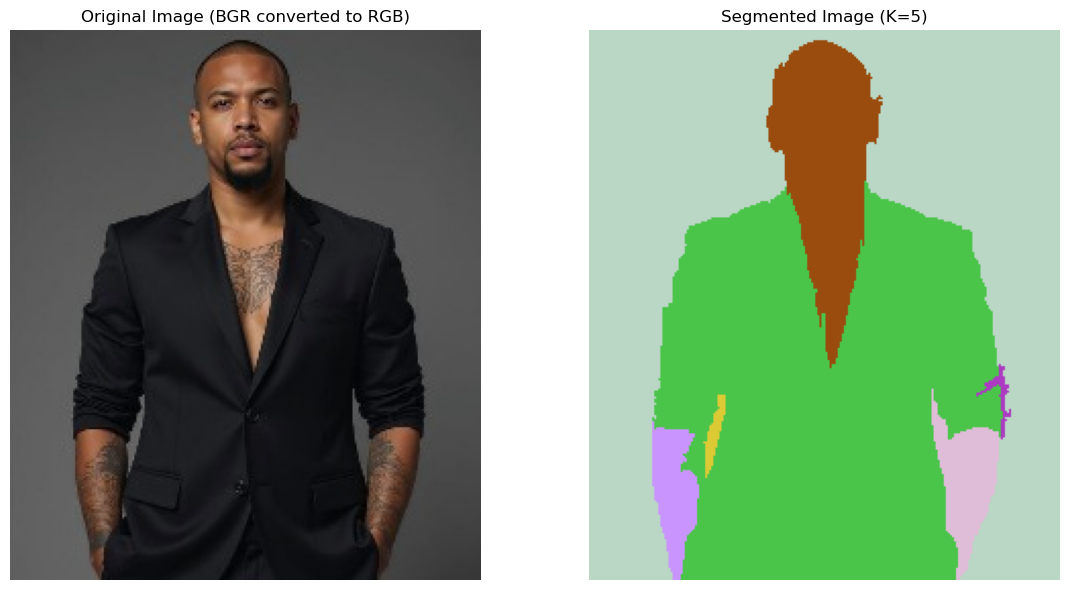

In [10]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries # Still useful for boundary visualization

# --- 1. Custom Disjoint Set Union (DSU) Structure ---
# (Keep the DSU class and graph_based_segmentation function exactly as defined previously)
class DSU:
    def __init__(self, num_elements):
        self.parent = list(range(num_elements))
        self.rank = [0] * num_elements
        self.size = [1] * num_elements
        self.num_sets = num_elements
        self.internal_difference = [0.0] * num_elements

    def find(self, i):
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i])
        return self.parent[i]

    def union(self, i, j, weight, k_val):
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            threshold_i = self.internal_difference[root_i] + k_val / self.size[root_i]
            threshold_j = self.internal_difference[root_j] + k_val / self.size[root_j]

            if weight <= threshold_i and weight <= threshold_j:
                self.num_sets -= 1

                if self.rank[root_i] < self.rank[root_j]:
                    root_i, root_j = root_j, root_i

                self.parent[root_j] = root_i
                self.size[root_i] += self.size[root_j]
                
                self.internal_difference[root_i] = max(self.internal_difference[root_i], 
                                                       self.internal_difference[root_j], 
                                                       weight)
                return True
        return False
# --------------------------------------------------------------------------

def graph_based_segmentation(img, sigma=0.5, k=500, min_size=100):
    start_time = time.time()

    img_float = img.astype(float) / 255.0
    smoothed_img = cv2.GaussianBlur(img_float, (0, 0), sigmaX=sigma, sigmaY=sigma)
    
    H, W, C = img.shape
    num_pixels = H * W
    edges = []

    for y in range(H):
        for x in range(W):
            current_idx = y * W + x
            
            def color_diff(p1, p2):
                return np.sqrt(np.sum((smoothed_img[p1[0], p1[1]] - smoothed_img[p2[0], p2[1]])**2))

            if x < W - 1:
                right_idx = y * W + (x + 1)
                weight = color_diff((y, x), (y, x + 1))
                edges.append((weight, current_idx, right_idx))

            if y < H - 1:
                bottom_idx = (y + 1) * W + x
                weight = color_diff((y, x), (y + 1, x))
                edges.append((weight, current_idx, bottom_idx))
                
    edges.sort(key=lambda x: x[0])

    dsu = DSU(num_pixels)
    
    for weight, u, v in edges:
        dsu.union(u, v, weight, k)

    for weight, u, v in edges:
        root_u = dsu.find(u)
        root_v = dsu.find(v)
        
        if root_u != root_v and (dsu.size[root_u] < min_size or dsu.size[root_v] < min_size):
            if dsu.rank[root_u] < dsu.rank[root_v]:
                root_u, root_v = root_v, root_u
            
            dsu.parent[root_v] = root_u
            dsu.size[root_u] += dsu.size[root_v]
            dsu.num_sets -= 1
            
    segment_map = np.zeros((H, W), dtype=np.int32)
    for y in range(H):
        for x in range(W):
            segment_map[y, x] = dsu.find(y * W + x)
            
    unique_segments = np.unique(segment_map)
    color_map = {segment_id: np.random.randint(0, 256, 3) for segment_id in unique_segments}
    
    segmented_img = np.zeros_like(img, dtype=np.uint8)
    for y in range(H):
        for x in range(W):
            segmented_img[y, x] = color_map[segment_map[y, x]]

    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"\n--- Segmentation Metrics ---")
    print(f"Number of segments found: {dsu.num_sets}")
    print(f"Execution time: {execution_time:.4f} seconds")
    
    return segmented_img, segment_map, execution_time # Also return segment_map for boundaries

# --- Main Execution and Matplotlib Visualization for Jupyter ---

# Placeholder image path - replace with your image!
image_file = 'person.jpg' 
# image_file = 'henri.jpg'
try:
    original_image = cv2.imread(image_file)
    if original_image is None:
        raise FileNotFoundError
except FileNotFoundError:
    print(f"Please place an image named '{image_file}' in the execution directory.")
    original_image = np.zeros((150, 250, 3), dtype=np.uint8) # Default black image

# Adjust parameters (Crucially: reduce K_THRESHOLD)
SIGMA = 0.5 
K_THRESHOLD = 5  # Reduced K to encourage more segments
MIN_SIZE = 100 

segmented_result_bgr, segment_map, time_taken = graph_based_segmentation(
    original_image, 
    sigma=SIGMA, 
    k=K_THRESHOLD, 
    min_size=MIN_SIZE
)

# --- Matplotlib Visualization (Inline Display) ---

# OpenCV uses BGR, Matplotlib uses RGB. We must convert for correct colors.
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
segmented_result_rgb = cv2.cvtColor(segmented_result_bgr, cv2.COLOR_BGR2RGB)

# Create a single figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title("Original Image (BGR converted to RGB)")
plt.axis('off')

# Subplot 2: Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_result_rgb)
plt.title(f"Segmented Image (K={K_THRESHOLD})")
plt.axis('off')

plt.tight_layout()
plt.show()

# You can also use mark_boundaries from skimage for a different visualization:
# boundary_image = mark_boundaries(original_image_rgb, segment_map, color=(1, 1, 0))
# plt.figure(figsize=(6, 6))
# plt.imshow(boundary_image)
# plt.title("Original Image with Segment Boundaries")
# plt.axis('off')
# plt.show()